In [1]:
from pathlib import Path
from top2vec import Top2Vec
import pickle
import numpy as np

from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import strip_tags

In [2]:
DATA_DIR = Path('./data')
def load(filename):
    f = open(DATA_DIR/filename,"rb")
    return pickle.load(f)
    
def save(data, filename):
    with open(DATA_DIR/filename, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [30]:

file = open("moties_processed_df.pickle","rb")
df = pickle.load(file)
print('before removal empty texts',len(df))

# remove moties without text
mask = (df['Text']=='') | (df['Text'].isna())
df = df.loc[~mask]
print('after removal empty texts',len(df))

documents = df['Text'].values

before removal empty texts 29514
after removal empty texts 29484


In [18]:
# got the code for making the bigram part from https://lppier.github.io/
sentence_stream = [simple_preprocess(strip_tags(doc), deacc=True) for doc in documents]
bigram = Phrases(sentence_stream, min_count=10)
bigram_phraser = Phraser(bigram)

indieners = {indiener[-1].lower() for indiener in df['Indiener_persoon'].str.split() if indiener}
years = {word for doc in sentence_stream for word in doc if word.startswith('x') and not word.startswith('xin')}
manual_stopwords = {'faber', 'lacin', 'kroger', 'iv', 'beschikt', 'die', 'vaststelling', 'lid','vi', 'viii', 'iii', 'iv', 'ii', 'i'}
stopwords = indieners | years | manual_stopwords
   
def bigram_stopword_preprocess(doc):
    sentence_stream = simple_preprocess(strip_tags(doc), deacc=True)
    sentence_stream = [word for word in sentence_stream if word not in stopwords]
    return bigram_phraser[sentence_stream]

In [19]:
model = Top2Vec(documents, speed='deep-learn', tokenizer=bigram_stopword_preprocess, workers=4)
model.get_num_topics()

2021-03-03 12:21:44,496 - top2vec - INFO - Pre-processing documents for training
2021-03-03 12:23:30,780 - top2vec - INFO - Creating joint document/word embedding
2021-03-03 13:16:48,205 - top2vec - INFO - Creating lower dimension embedding of documents
2021-03-03 13:18:06,879 - top2vec - INFO - Finding dense areas of documents
2021-03-03 13:18:13,374 - top2vec - INFO - Finding topics


247

In [20]:
model.save("data/doc2vec_deep_bigram_enhanced_stopwords")

In [10]:
model = Top2Vec.load("data/doc2vec_deep_bigram_enhanced_stopwords")
model.get_num_topics()

In [21]:
def get_reduced_topics(num_topics):
    print(f'performing reduction to {num_topics} topics')
    reduced_topics = model.hierarchical_topic_reduction(num_topics)
    topic_words, word_scores, topic_nums = model.get_topics(reduced=True)
    reduced_topics = tuple(tuple(sorted(t)) for t in reduced_topics)
    return reduced_topics, topic_words

def find_diff(reduced1, reduced2, reverse=False):
    # find the topics that where merged and return their index
    if not reverse:
        changed = set(reduced1) - set(reduced2)
        return [index for index, topic in enumerate(reduced1) if topic in changed]
    else:
        changed = set(reduced2) - set(reduced1)
        return [index for index, topic in enumerate(reduced2) if topic in changed]


def print_merge(large, small, num_words=50):
    print(f'\ninspecting difference from {len(large[0])} to {len(small[0])} topics')
    print('old topics')
    for i in find_diff(large[0],small[0]):
        print(large[1][i][:num_words])
    print('new topic')
    for i in find_diff(large[0],small[0], reverse=True):
        print(small[1][i][:num_words])
start = 17
stop = 6
reductions = {i: get_reduced_topics(i) for i in range(start, stop, -1)}
for i in range(start, stop +1,-1):
    print(i)
    print_merge(reductions[i], reductions[i-1])

In [100]:

# Make a choice to how many topics to reduce
num_topics = 16
reduced_topics = model.hierarchical_topic_reduction(num_topics)


In [101]:
# inspect number of documents for each topic
topic_sizes, topic_nums = model.get_topic_sizes(reduced=True)
topic_words, word_scores, topic_nums = model.get_topics(reduced=True)

In [26]:
for i, t in enumerate(topic_words):
    print(i,t)

0 ['onderwijs_cultuur' 'wetenschap_viii' 'onderwijs' 'leerlingen'
 'voortgezet_onderwijs' 'viii' 'scholen' 'primair_onderwijs' 'mbo'
 'volwassenen_educatie' 'leerling' 'hoger_onderwijs' 'passend_onderwijs'
 'studenten' 'leraren' 'diploma' 'docenten' 'hbo' 'vakken' 'onderwijsveld'
 'funderend_onderwijs' 'docent' 'talenten' 'school' 'opleiding' 'celik'
 'vo' 'mbo_studenten' 'opleidingen' 'schooljaar' 'basisonderwijs'
 'hogescholen' 'curriculum' 'vmbo' 'havo' 'student' 'eindtoets'
 'bekostiging' 'leraar' 'voortgezet_speciaal' 'wet_educatie' 'doorstroom'
 'lerarentekort' 'middelbaar' 'schooladvies' 'wetenschap' 'werkdruk'
 'speciaal_onderwijs' 'klas' 'expertisecentra']
1 ['buitenlandse_zaken' 'jbz_raad' 'landen' 'vn' 'humanitaire'
 'buitenlandse_handel' 'mensenrechten' 'afghanistan' 'syrie' 'jemen'
 'vluchtelingen' 'saudi_arabie' 'turkije' 'bestrijding_internationaal'
 'actuele_situatie' 'verenigde_naties' 'internationale'
 'buitenlands_beleid' 'unhcr' 'libie' 'palestijnse_autoriteit' 'oor

In [110]:
def generate_topic_wordcloud(self, topic_num, background_color="black", reduced=False, text = None):
        """
        Create a word cloud for a topic.
        A word cloud will be generated and displayed. The most semantically
        similar words to the topic will have the largest size, less similar
        words will be smaller. The size is determined using the cosine distance
        of the word vectors from the topic vector.
        Parameters
        ----------
        topic_num: int
            The topic number to search.
        background_color : str (Optional, default='white')
            Background color for the word cloud image. Suggested options are:
                * white
                * black
        reduced: bool (Optional, default False)
            Original topics are used by default. If True the
            reduced topics will be used.
        Returns
        -------
        A matplotlib plot of the word cloud with the topic number will be
        displayed.
        """

        if reduced:
            self._validate_hierarchical_reduction()
            self._validate_topic_num(topic_num, reduced)
            word_score_dict = dict(zip(self.topic_words_reduced[topic_num],
                                       softmax(self.topic_word_scores_reduced[topic_num])))
        else:
            self._validate_topic_num(topic_num, reduced)
            word_score_dict = dict(zip(self.topic_words[topic_num],
                                       softmax(self.topic_word_scores[topic_num])))

        plt.figure(figsize=(4, 1),
                   dpi=200)
        plt.axis("off")
        plt.imshow(
            WordCloud(width=400,
                      height=100,
                      background_color=background_color).generate_from_frequencies(word_score_dict))
        plt.title(f'Onderwerp #{topic_num}, ingedeeld als: {text}', loc='left', fontsize=6, pad=1)
model.generate_topic_wordcloud = generate_topic_wordcloud

In [112]:
for i, topic in enumerate(topic_words):
    # print(f'\nOnderwerp {i+1}, geclassificeerd als: {topics[i]}:\n{words}')
    model.generate_topic_wordcloud(model, topic_num = i, reduced=True, text = topics[i])


Onderwerp 1, geclassificeerd als: Onderwijs:
woningmarkt huurders integrale_visie woningen huur binnenlandse_zaken vii corporaties huurwoningen woning wonen rijksdienst sociale_huurwoningen verhuurders huurbeleid huren huurverhoging starters nieuwbouw woningwet

Onderwerp 2, geclassificeerd als: Buitenlandse zaken:
woningmarkt huurders integrale_visie woningen huur binnenlandse_zaken vii corporaties huurwoningen woning wonen rijksdienst sociale_huurwoningen verhuurders huurbeleid huren huurverhoging starters nieuwbouw woningwet

Onderwerp 3, geclassificeerd als: Algemene zaken:
woningmarkt huurders integrale_visie woningen huur binnenlandse_zaken vii corporaties huurwoningen woning wonen rijksdienst sociale_huurwoningen verhuurders huurbeleid huren huurverhoging starters nieuwbouw woningwet

Onderwerp 4, geclassificeerd als: Natuur & gaswinning:
woningmarkt huurders integrale_visie woningen huur binnenlandse_zaken vii corporaties huurwoningen woning wonen rijksdienst sociale_huurwonin

KeyboardInterrupt: 

In [67]:
topic_words, word_scores, topic_scores, topic_nums = model.search_topics(keywords=["coronavirus"], num_topics=5)
topic_nums

array([ 51,  86, 206, 227,  95], dtype=int64)

In [68]:
for t in topic_nums:
    for i, r in enumerate(reduced_topics):
        if t in r: print(i)

11
4
11
5
5


In [69]:
topic_scores

array([0.3737805 , 0.18866851, 0.14131826, 0.13716154, 0.13366434])

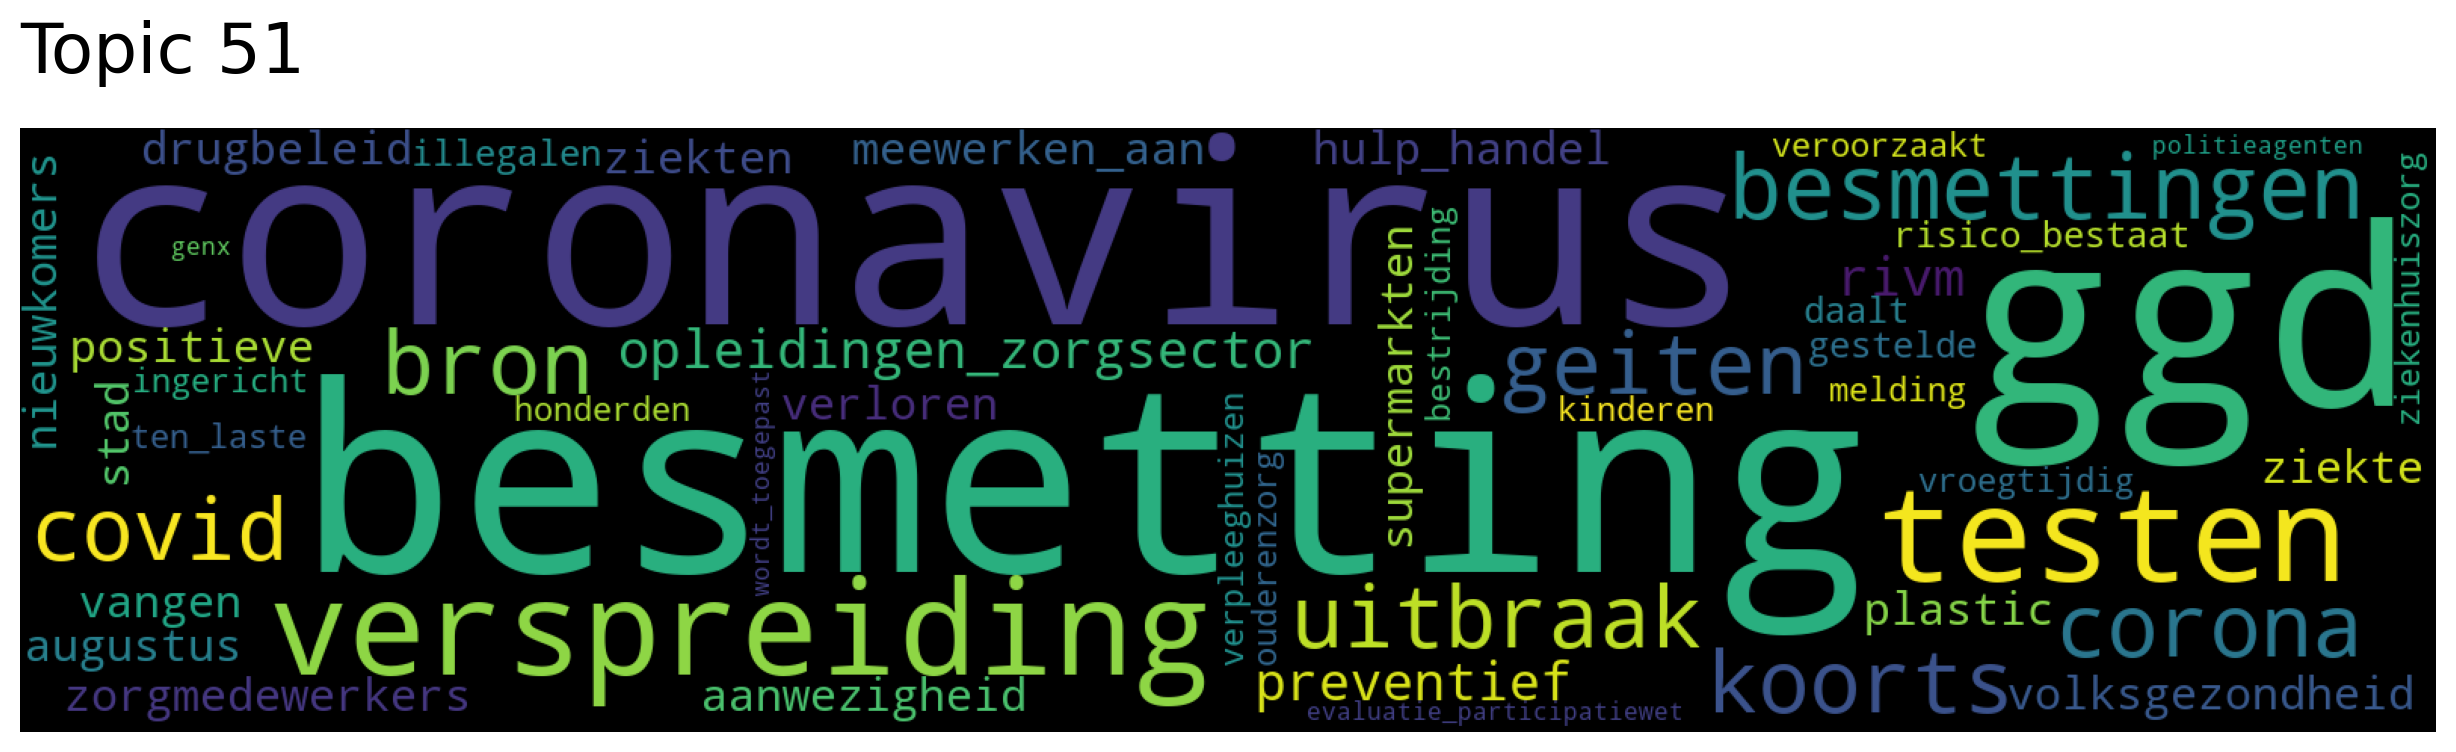

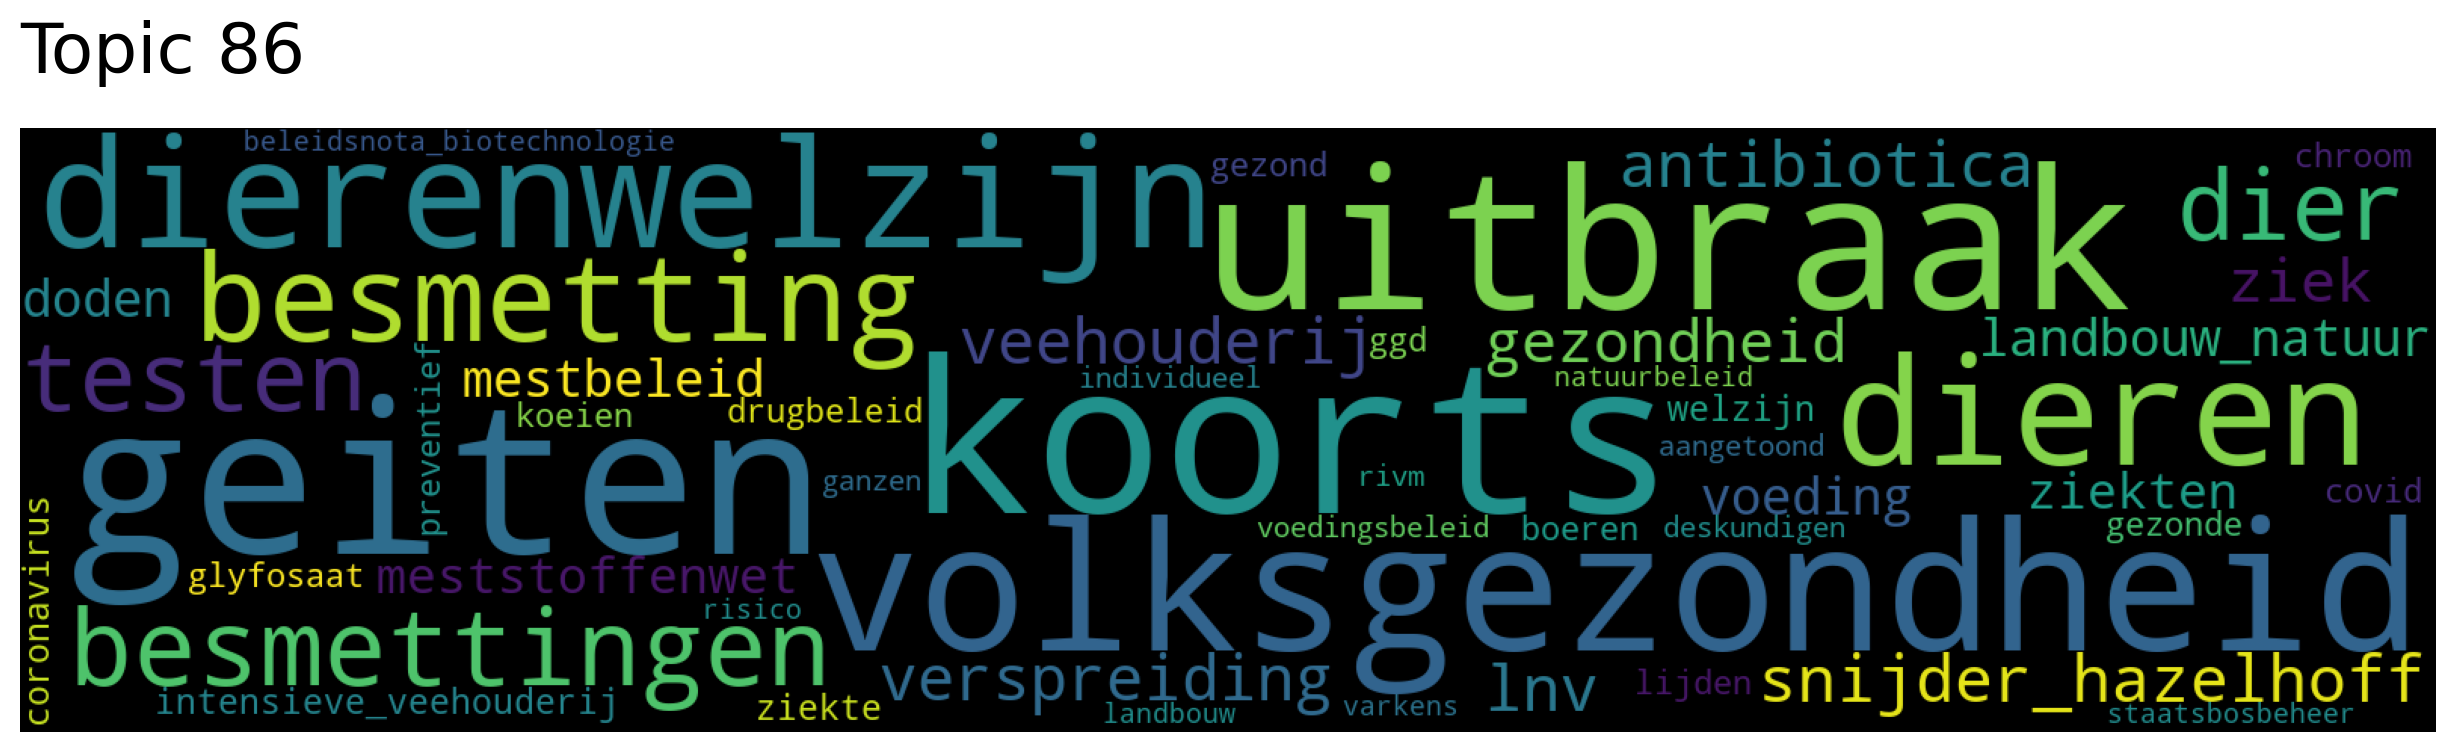

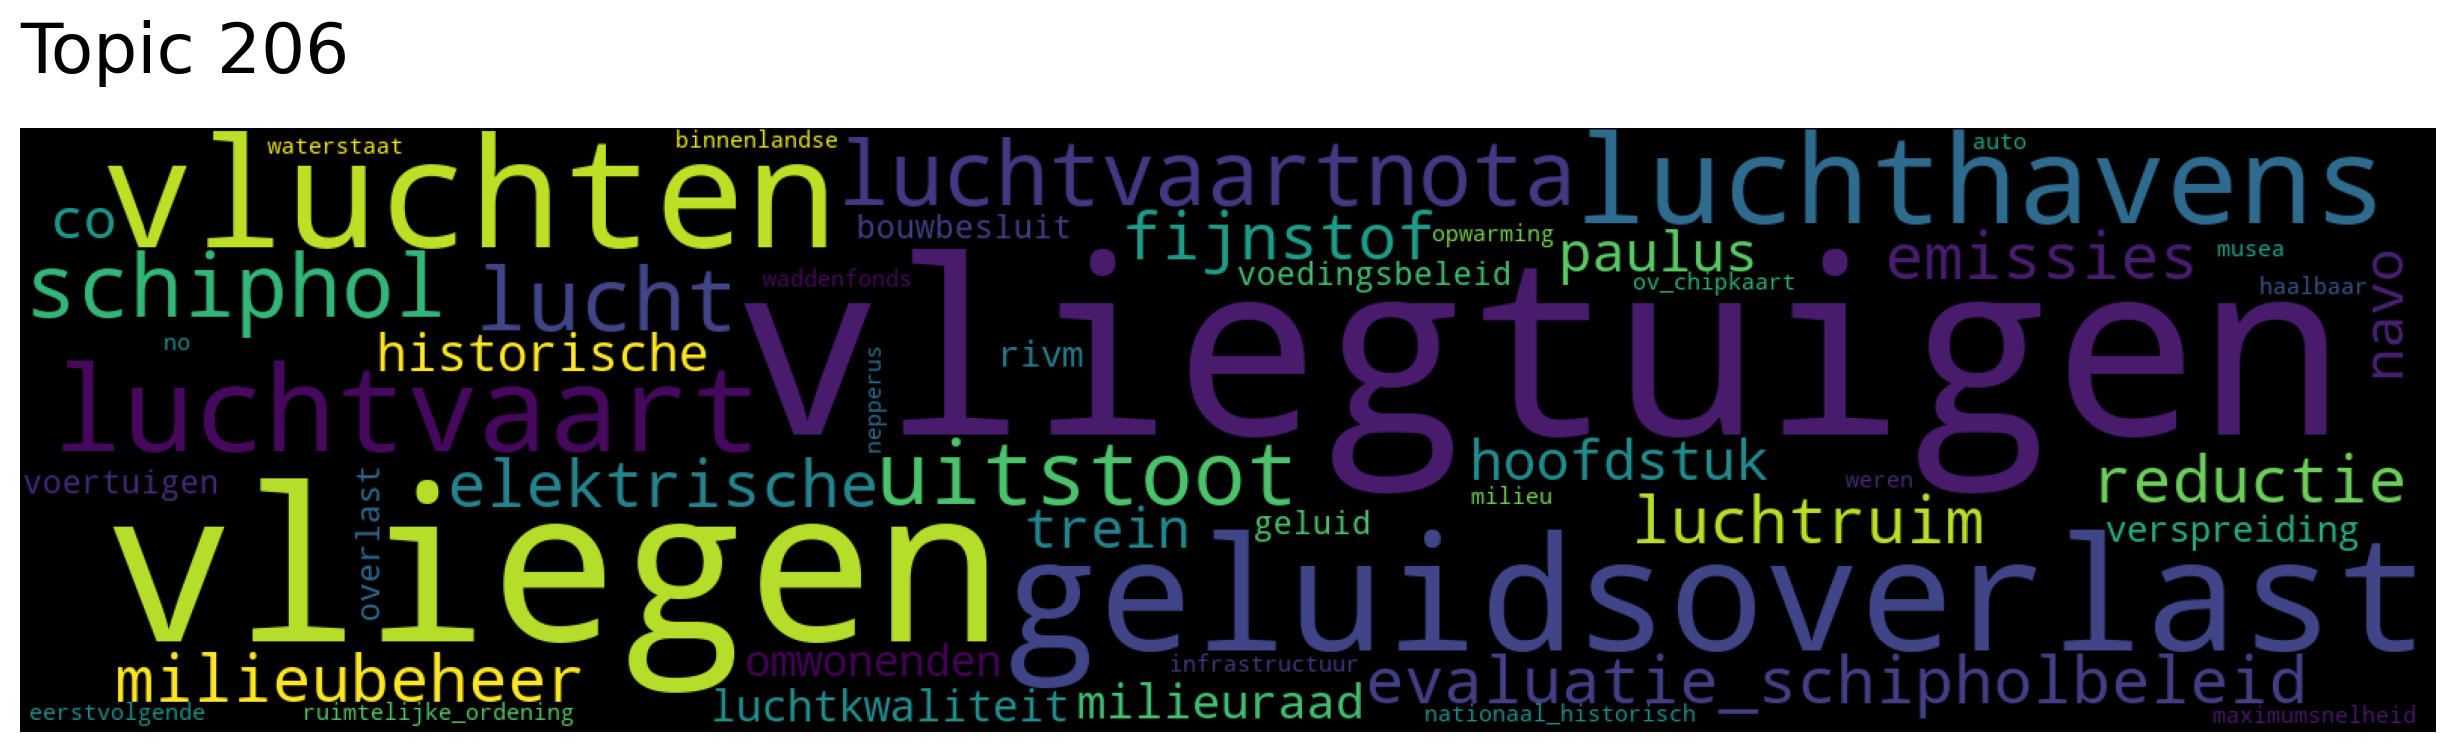

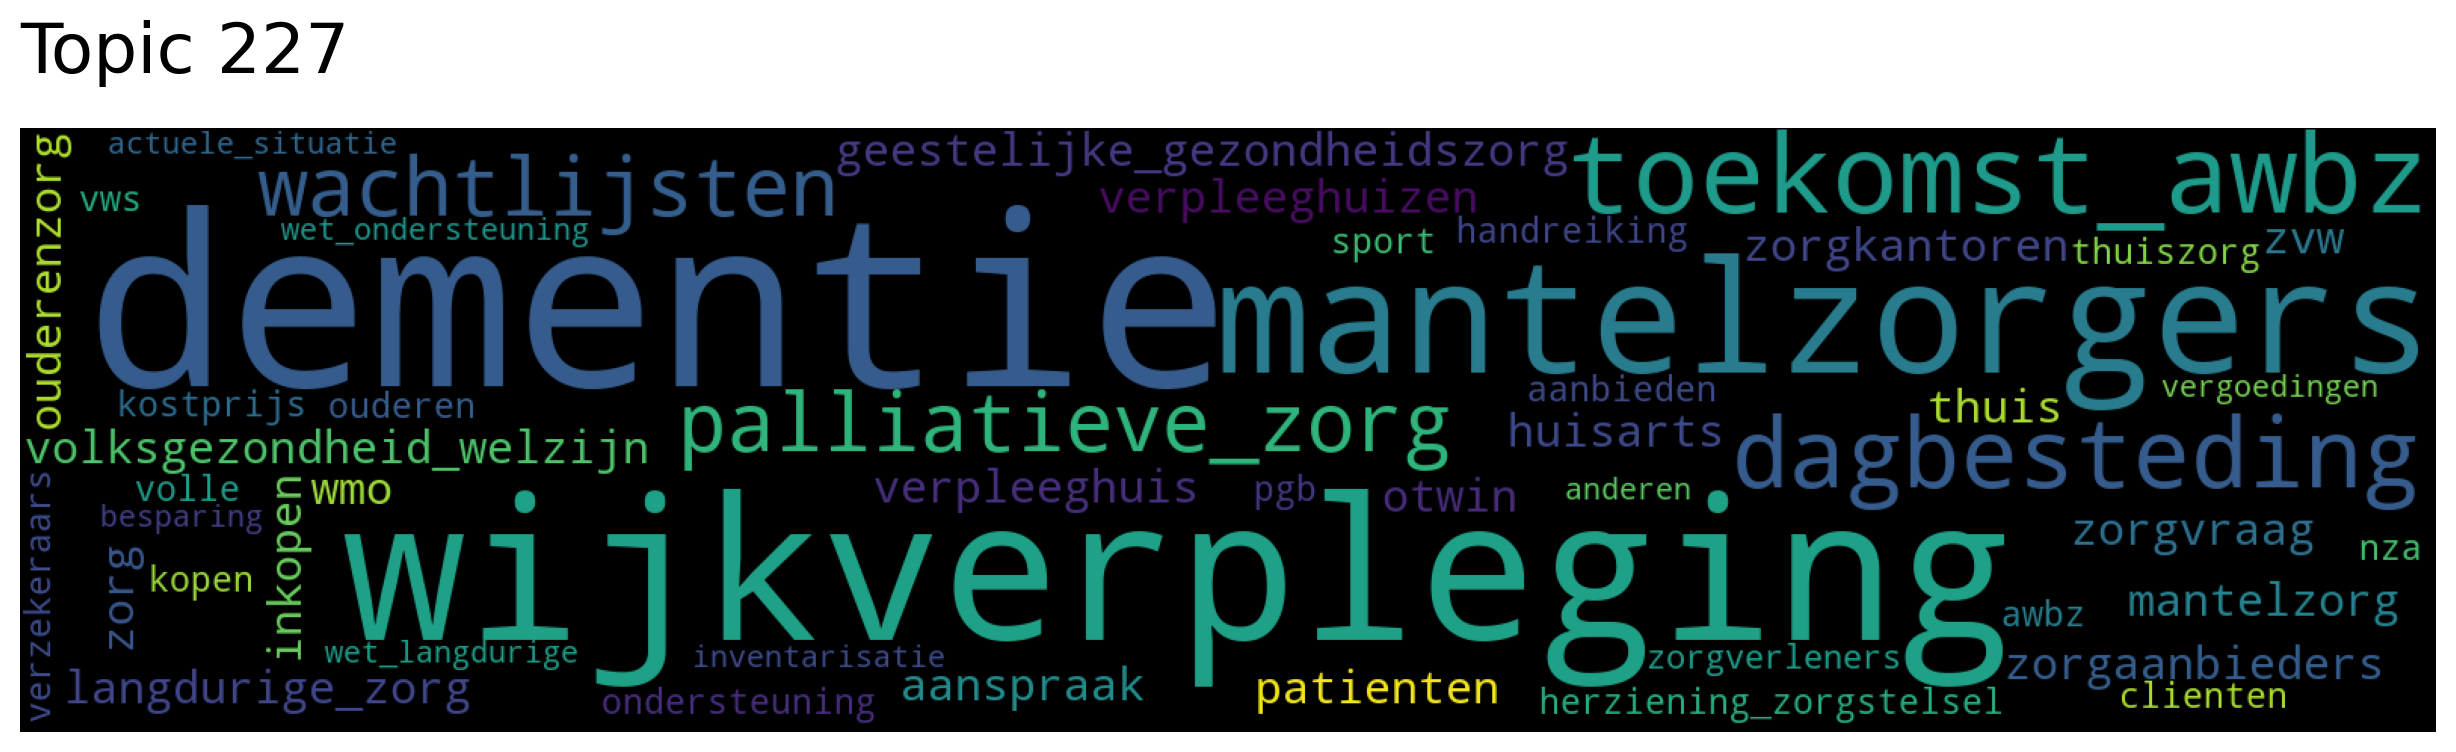

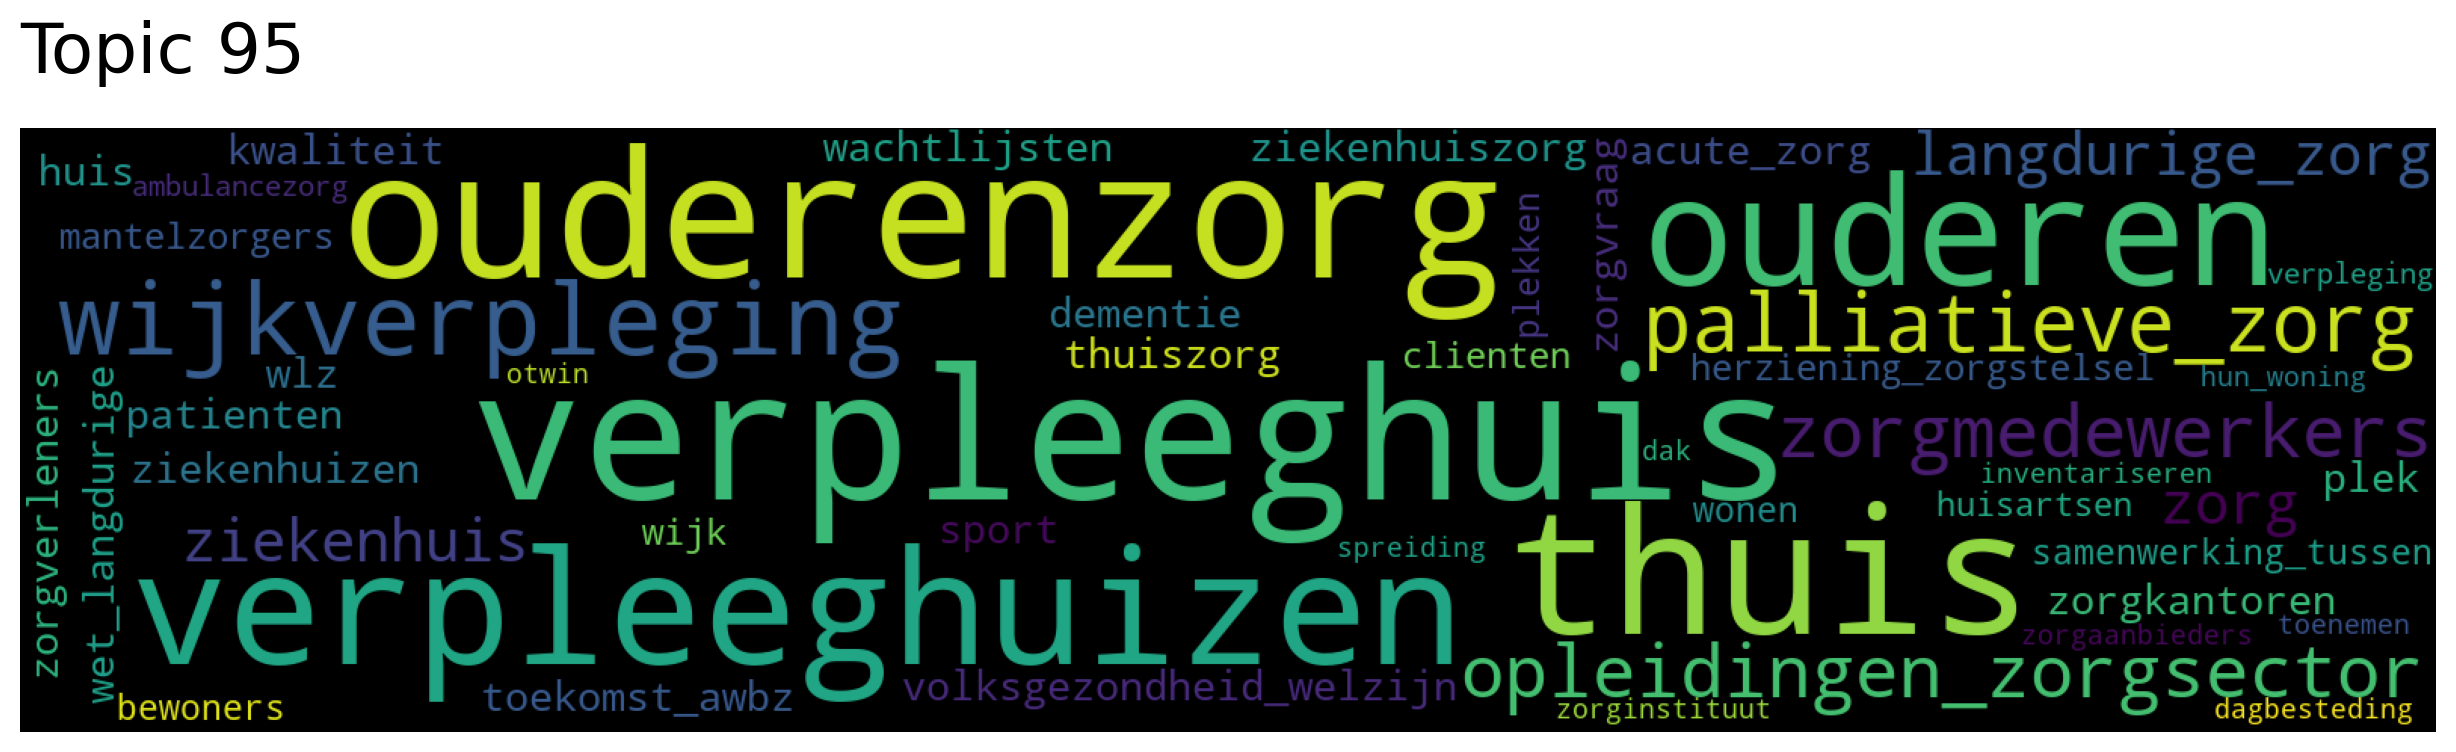

In [72]:
topic_words, word_scores, topic_scores, topic_nums = model.search_topics(keywords=["coronavirus"], num_topics=5, reduced=False)
for topic in topic_nums:
    model.generate_topic_wordcloud(topic)

In [33]:
doc_ids = list(range(len(documents)))
topic_nums, topic_score, topic_words, word_scores = model.get_documents_topics(doc_ids,reduced=True)

In [46]:
topics = {
  0: 'Onderwijs',  
  1: 'Buitenlandse zaken',  
  2: 'Algemene zaken',  
  3: 'Natuur & gaswinning',  
  4: 'Landbouw & dierenwelzijn',  
  5: 'Zorg',  
  6: 'Sociale zaken',  
  7: 'Justitie',  
  8: 'Pensioenstelsel',  
  9: 'Europese Unie',  
  10: 'Klimaat & energie',  
  11: 'Milieu & regelgeving',  
  12: 'Zorg',  
  13: 'Openbaar vervoer',  
  14: 'Financiele sector',  
  15: 'Wonen'
  }

doc_ids = list(range(len(documents)))
topic_nums, topic_score, topic_words, word_scores = model.get_documents_topics(doc_ids,reduced=True)
topic_names = [topics[t] for t in topic_nums]
assert len(topic_nums) == len(df)
df['Topic'] = topic_names
topic_nums, topic_score, topic_words, word_scores = model.get_documents_topics(doc_ids,reduced=False)
df['Topic_initial'] = topic_nums

In [49]:
df['Topic_initial']

2009Z00479     61
2009Z00488     61
2009Z00489     61
2009Z00490     61
2009Z00483     54
             ... 
2020Z25826     33
2020Z25819    104
2020Z25825    104
2020Z25824    104
2020Z25822     30
Name: Topic_initial, Length: 29484, dtype: int32

In [35]:
save(df[:1000], 'df_including_topics.pickle')
save(df, 'df_including_topics_full.pickle')

In [79]:
num_topics = 1
reduced_topics = model.hierarchical_topic_reduction(num_topics)
topic_sizes, topic_nums = model.get_topic_sizes(reduced=True)
topic_words, word_scores, topic_nums = model.get_topics(reduced=True)

In [115]:
from collections import Counter
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('dutch')
count = Counter([word for doc in sentence_stream for word in doc if word not in stop_words])
WordCloud(width=600, height=400, background_color='yellow').generate_from_frequencies(count).to_file('wordcloud.png')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jesse\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
